# Multivariate time series: training and analysis

This notebook provides example code you can use for training and analysing your models. Note that **it is not advised** to run and train all models for this assignment in a single notebook. Ideally, in order not to loose your way in your own notebooks, you make **at least** a separate notebook for each type of model in this assignment, selecting only the code you need for that model.

You can get additional inspiration from the "Time series forecasting" demo notebook from the Tensorflow docs:

https://www.tensorflow.org/tutorials/structured_data/time_series

This notebook heavily uses tensorflow utilities we haven't seen in class yet and is sometimes less easy to follow. We use some of the helper functions from that notebook in the code below.

## Imports and Drive mounting


In [1]:
#imports and Drive mounting
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn as sk
import pandas as pd
from pandas import read_csv
from datetime import datetime
import math
import os

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)  

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.losses import MAE


TensorFlow 2.x selected.
2.1.0


## Assignment overview

The text below is de same as the text at the end of the preprocessing notebook. 

**However, one important piece of information was missing: we will use MAE (mean absolute error) to evaluate our models.**

In your last graded assignment, you will build a model to predict pollution in a big city on past pollution info as well as past wheather info. You receive a multi-variate time series data set which contains hourly data. 
**Your task is to predict pollution 6 hours ahead** in order to be able to build a citizen warning system. The error measure you need to minimise is Mean Absolute Error. You will **use the pollution samples from the last year for testing**. Obviously, it is also advisable to use a validation set.


Your assignment consists of three steps (please also check the instructions in the slides):

1) First make the following baseline model:

a model that only predicts pollution based on the current values of all input time series (pollution and wheather) to predict for 6 hours ahead, i.e. a purely feature based dense model that does not take history into account; you can also use this  model for an initial investigation of the importance of each feature! 
Note that we already provide an even simpler baseline that simply uses the current pollution value as a prediction.

2) After this baseline, you will make two models that predict pollution 6 hours ahead based on **current pollution and pollution history**, so a single timeseries:
- a window-based 1D convolution network (the window size is an important hyperparameter here)
- a RNN network (LSTM and/or GRU)

3) Combine both into a model that uses current values and histories of multiple time series. You do not need to use all of them if they do not improve validation score. You will analyse the impact of including the different wheather features into your model (feature selection). 

4) You will finally try to crank up your performance by making at least one ensemble. For example, for some features it may not be useful to use history information. You could consider buildin an ensemble of a sequential model with a dense model or of models trained on different subsets of the features.

## Analysis

Since this is a regression task, there are no misclassifications: the analysis should focus on visualising the predictions on train and validate or test sets. Code for this is suggested in the training notebook. Please make sure to not only make the necessary plots, ut also to discuss them for the final model(s) in each stage.

## Timing

**This assignment is considerably more extensive than the previous ones!** try to maximally use the experience you already gained to efficiently tune the networks. Also, once you find a network that is properly tuned, do not waste time on trying to get that extra small improvement. If you have time left after finishing all the tasks, you can still revisit your best model(s) to try and improve!

The deadline for this assignment is **Friday, March 20, 23:30**. 
This means you have 2 weeks: for a good planning, aim at finishing at least parts 1 and 2 in the first week! That way, you can use the hands-on support session to ask us whether you are on the right track.




In [0]:
# uncomment if you want to use Drive

#from google.colab import drive
#drive.mount('/content/gdrive')
#

##!ls '/content/gdrive/My Drive/'

## Reading the data set

The code below reads the train and test datasets that were generated by the preprocessing notebooks. Obviously: feel free to create your own feature sets, and to change the filenames and paths as you need.


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f736c204c88>,
      dtype=object)

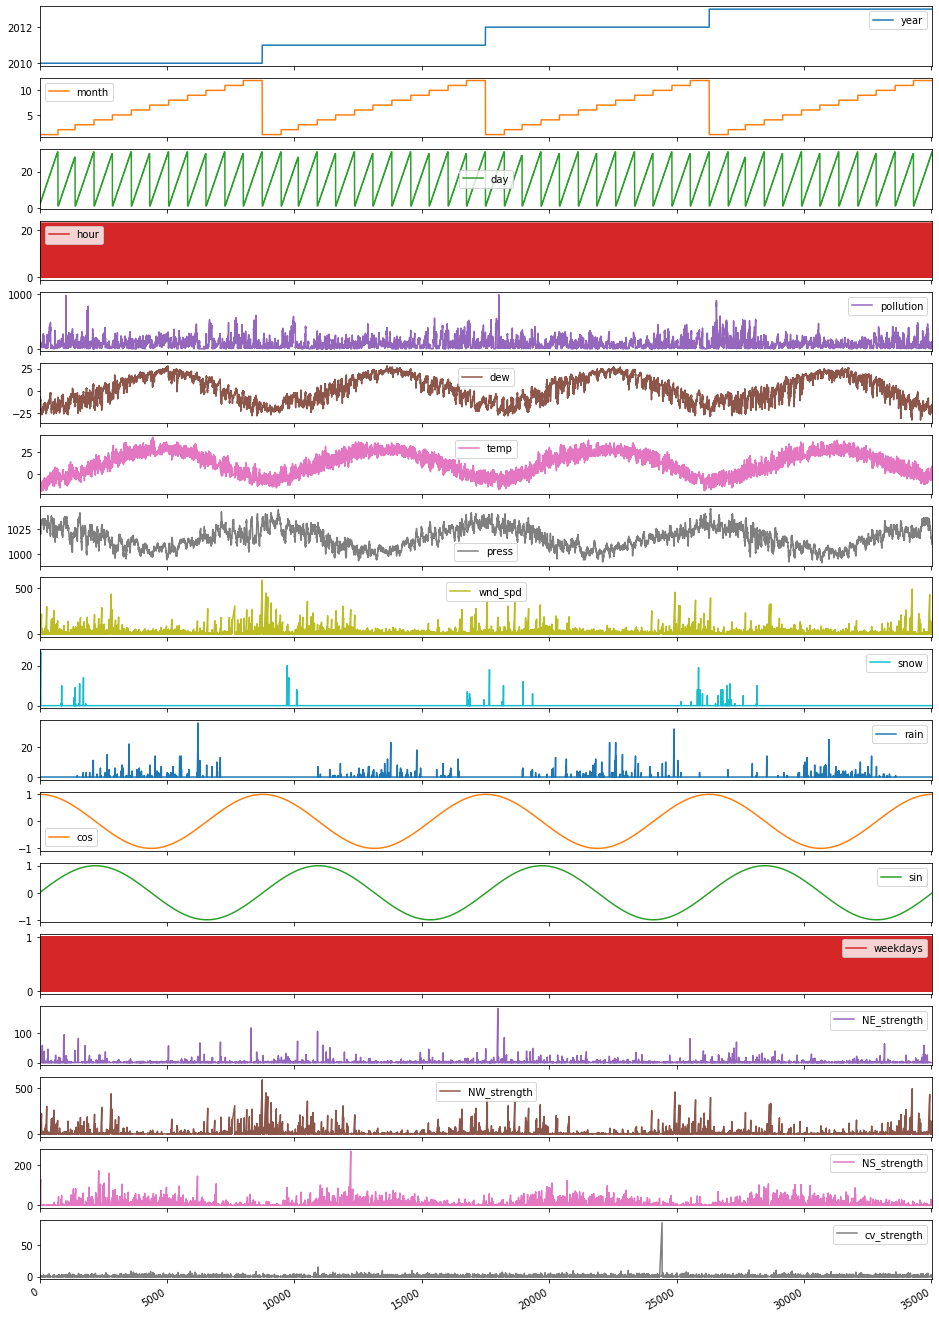

In [3]:
# load dataset

# this code only loads train and test datasets

# remember you also need to split off a validation dataset
# either by reusing and adapting the splitting code from the preprocessing notebook 
# or by writing your own code
# like in the previous assignments, this means you should have 4 sets:

# train_all (train+validate), train, validate and test

# The PATH setting below assumes you just uploaded the data file to your Colab session
# When using Drive: replace this by the path where you put the data file
DATAPATH = './'  
TRAINDATAFILE = DATAPATH+'preprocessed_train_data.csv'
TESTDATAFILE = DATAPATH+'preprocessed_test_data.csv'

train_dataset = read_csv(TRAINDATAFILE, header=0, index_col=0)
test_dataset = read_csv(TESTDATAFILE, header=0, index_col=0)

#check - note that you can make many other plots directly from pandas dataframes:
# https://pandas.pydata.org/pandas-docs/version/0.16/visualization.html

train_dataset.plot(subplots=True,figsize=(16,26))

## Extract train, validate and test features and labels

In the code below, we will split of an arbitrary number of 5000 samples at the end of the training set as validation data. It is up to you to decide how much data you split off.

In [4]:
# extract data from dataframes, selecting the features you want
# note that the labels simply contain the pollution data for now
# depending on the window sizes used in training, the correct values will be cut out

nval = 5000
features = [4,5,6,7,11,12,13,14,15,16]
pollution = 4


# Important: Tensorflow 2.x gives an error if you omit
# the np.asarray(...,,dtype=np.float32)

train_all_values = np.asarray(train_dataset.values[:,features],dtype=np.float32)
train_all_labels = np.asarray(train_dataset.values[:,pollution],dtype=np.float32)
train_values = np.asarray(train_dataset.values[:-nval,features],dtype=np.float32)
train_labels = np.asarray(train_dataset.values[:-nval,pollution],dtype=np.float32)
val_values = np.asarray(train_dataset.values[-nval:,features],dtype=np.float32)
val_labels = np.asarray(train_dataset.values[-nval:,pollution],dtype=np.float32)
test_values = np.asarray(test_dataset.values[:,features],dtype=np.float32)
test_labels = np.asarray(test_dataset.values[:,pollution],dtype=np.float32)

print(train_all_values.shape)
print(train_all_labels.shape)
print(train_values.shape)
print(train_labels.shape)
print(val_values.shape)
print(val_labels.shape)
print(test_values.shape)
print(test_labels.shape)


(35040, 10)
(35040,)
(30040, 10)
(30040,)
(5000, 10)
(5000,)
(8760, 10)
(8760,)


## Normalising the data

As you know by now, it is important to normalise the data. The flow is the following:

- initialise normaliser 1
- fit on training date
- use it to transform train and validation data

For your final model(s) you need a second normaliser:
- initialise normaliser 2
- fit on training+validation data
- use it to transform training+validation and test data

This has to be done **before** reformatting the data into windows (next section). 

Although we already did this before, the code below gives an example (adapt teh code after you've defined a validation set:


In [0]:
# imports to show that there are many different scalers
# especially with recurrent NNs, the choice of scaler can make a difference
# look up what they do before choosing which one to try

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

# Example: train standard scalers, apply to train and test data
# adapt to do all you need to do ...

SS1 = StandardScaler()
SS1.fit(train_values)

train_scaled = SS1.transform(train_values)
val_scaled = SS1.transform(val_values)

SS2 = StandardScaler()
SS2.fit(train_all_values)

train_all_scaled = SS2.transform(train_all_values)
test_scaled = SS2.transform(test_values)

## Transforming the data into the right format for model training

In this assignment, you will use models with two types of inputs: 
- a dense network that only uses the current input features for prediction
- window-based and sequential networks that use time windows for prediction

In the code below, we define a helper function for each case.

In [6]:
# dense network:
# here you only need to take into account that we are predicting 6 steps ahead
# this means that the features of the first timestep (index 0)
# are used to predict the 7th pollution value (index 6) so the first 6 and the last 6 feature-samples labels are omitted

def create_dataset_dense(train, test, ahead=6):   # can use this with different 'ahead' values, but default is set to 6
    return train[:-ahead,:], test[ahead:]

X_train_d,r_train_d = create_dataset_dense(train_scaled,train_labels)
X_val_d,r_val_d = create_dataset_dense(val_scaled,val_labels)

X_train_all_d,r_train_all_d = create_dataset_dense(train_all_scaled,train_all_labels)
X_test_d,r_test_d = create_dataset_dense(test_scaled,test_labels)


print(X_train_d.shape)
print(r_train_d.shape)

(30034, 10)
(30034,)


In [7]:
# window-based and recurrent networks:
# now, you use a window of k history values to predict
# this means that the features of the first k timesteps (indices 0 to k-1)
# are used to predict the k+6th pollution value (index k+6-1)
# output dimension of train data is samples x window x features

def create_dataset_windowed(train, test, ahead=6, window_size=1):
  samples = train.shape[0]-ahead-(window_size-1) 
  dataX= []
  for i in range(samples):
      a = train[i:(i+window_size), :]
      dataX.append(a)
  return np.array(dataX), test[ahead+window_size-1:]

WINDOW=3
X_train_w,r_train_w = create_dataset_windowed(train_scaled,train_labels, window_size=WINDOW)
X_val_w,r_val_w = create_dataset_windowed(val_scaled,val_labels, window_size=WINDOW)

X_train_all_w,r_train_all_w = create_dataset_windowed(train_all_scaled,train_all_labels, window_size=WINDOW)
X_test_w,r_test_w = create_dataset_windowed(test_scaled,test_labels, window_size=WINDOW)

print(X_train_w.shape)
print(r_train_w.shape)



(30032, 3, 10)
(30032,)


## Simplest sandbox model

The simplest sandbox model you can make just uses the current pollution to predict the pollution of 6 hours ahead. In the code below, we create these predictions, and evaluate them, using a 'Plotresults' function.

In [8]:
# We use current pollution as prediction for the "dense" labels


from sklearn.metrics import mean_absolute_error
y_train_current = train_values[:-6,0]
y_val_current = val_values[:-6,0]

mae_train_current = mean_absolute_error(r_train_d,y_train_current)
mae_val_current = mean_absolute_error(r_val_d,y_val_current)

print("\"Current pollution\" baseline:\n train mae = ",mae_train_current,
      "\n validation mae = ",mae_val_current)


"Current pollution" baseline:
 train mae =  40.496937 
 validation mae =  39.470764


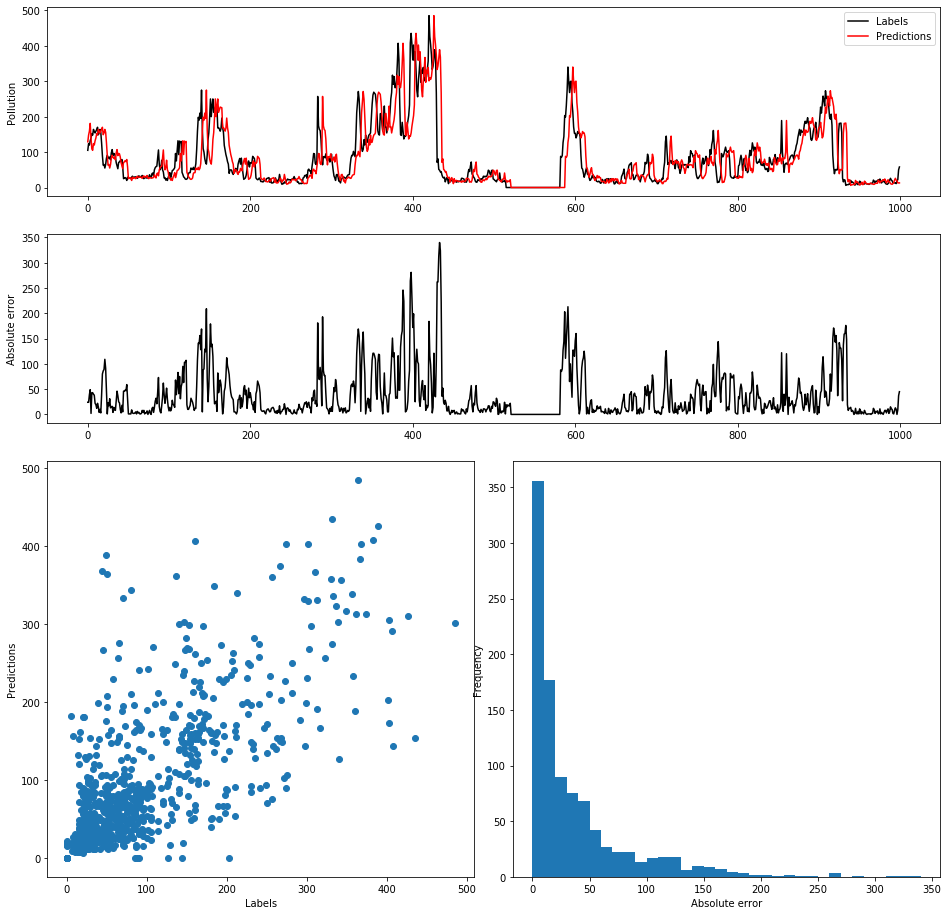

In [9]:
def PlotResults(labels,predictions,binsize = 10):
  num_samples = len(labels)
  
  fig = plt.figure(figsize=(16,16))
  spec = gridspec.GridSpec(ncols=4, nrows=4, figure=fig)
  ax1 = fig.add_subplot(spec[0, :])
  ax2 = fig.add_subplot(spec[1, :])
  ax3 = fig.add_subplot(spec[2:,0:2])
  ax4 = fig.add_subplot(spec[2:,2:])
  
  ax1.plot(labels,'k-',label='Labels')
  ax1.plot(predictions,'r-',label='Predictions')
  ax1.set_ylabel('Pollution')
  ax1.legend()
  
  errors=np.absolute(labels-predictions)
  ax2.plot(errors,'k-')
  ax2.set_ylabel("Absolute error")
  
  ax3.scatter(labels,predictions)
  ax3.set_xlabel('Labels')
  ax3.set_ylabel('Predictions')

  bins = np.arange(0,(np.ceil(np.max(errors)/binsize)+1)*binsize,binsize)
  
  ax4.hist(errors,bins=bins)
  ax4.set_xlabel('Absolute error')
  ax4.set_ylabel('Frequency')

  plt.show()

# Visualise first 1000 predictions
PlotResults(r_train_d[:1000],y_train_current[:1000])

## Building models

The code below offers a quick and dirty overview of hor to construct and train models of different types (very similar to the time series forecasting demo notebook used in class).

In [10]:
print(X_val_d.shape)
print(r_val_d.shape)


# Stage 1 model: dense model only using current features for prediction
# uses datasets with '_d' 



# put model in a function wrapper
# this model assumes dropout on all layers, including the input layer
# without specifying any hidden layers this is just linear regression

# note that this will give an error if the number of dropouts does not equal the number of hiddens+1
# and as always: feel free to use your own functions

def my_Dense(num_features,learning_rate=0.001,hidden=[],ridge_param = 0.0,dropouts=[0.0]):
    # create linear modelmodel

    model = Sequential()
    model.add(Dropout(dropouts[0], input_shape=(num_features,)))
    for idx in range(len(hidden)):
      model.add(Dense(hidden[idx],activation = 'ReLu',kernel_regularizer=tf.keras.regularizers.l2(ridge_param)))
      model.add(Dropout(dropouts[idx+1]))
    model.add(Dense(1,activation='linear',kernel_regularizer=tf.keras.regularizers.l2(ridge_param)))
    
    optim = tf.keras.optimizers.Adam(lr=learning_rate)
    # Compile model
    model.compile(loss='mae', optimizer=optim, metrics=['mae']) # keep extra metrics: mse and mae without regularisation terms
    return model    


linreg = my_Dense(X_train_d.shape[1],learning_rate=0.01)

# and check whether everything is as you expected
linreg.summary()

batch_size=64
epochs=30
linreg_history = linreg.fit(X_train_d, r_train_d,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val_d, r_val_d),
          shuffle=True)



(4994, 10)
(4994,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout (Dropout)            (None, 10)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 11
Trainable params: 11
Non-trainable params: 0
_________________________________________________________________
Train on 30034 samples, validate on 4994 samples
Epoch 1/30
30034/30034 [==============================] - 1s 34us/sample - loss: 92.1261 - mae: 92.1261 - val_loss: 84.2380 - val_mae: 84.2379
Epoch 2/30
30034/30034 [==============================] - 1s 25us/sample - loss: 87.8771 - mae: 87.8771 - val_loss: 81.0012 - val_mae: 81.0012
Epoch 3/30
30034/30034 [==============================] - 1s 23us/sample - loss: 83.8372 - mae: 83.8372 - val_loss: 77.2043 - val_mae: 77.2043
Epoch 4/30
30034/30034 [=

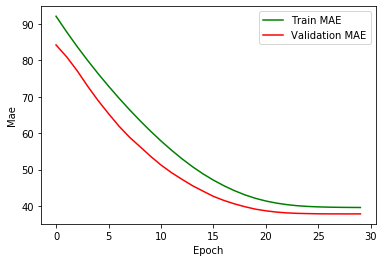

In [11]:
def plot_history(history):
  plt.figure(figsize = (6,4))
  
  plt.xlabel('Epoch')
  plt.ylabel('Mae')
  plt.plot(history.epoch, np.array(history.history['mae']),'g-',
           label='Train MAE')
  plt.plot(history.epoch, np.array(history.history['val_mae']),'r-',
           label = 'Validation MAE')
  plt.legend()
  plt.show()

plot_history(linreg_history)

"Current pollution" baseline:
 train mae =  39.55391 
 validation mae =  37.80819
(30034, 1)
(4994, 1)


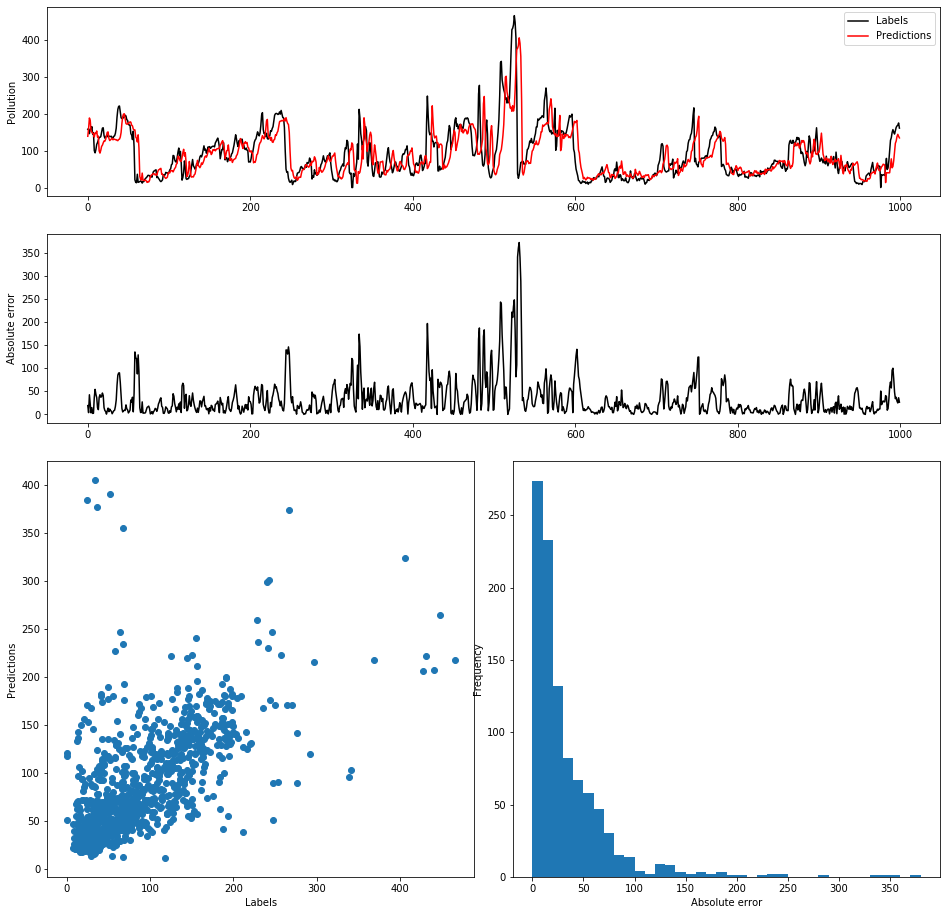

In [12]:
y_train_linreg = linreg.predict(X_train_d)
y_val_linreg = linreg.predict(X_val_d)

mae_train_linreg = mean_absolute_error(r_train_d,y_train_linreg)
mae_val_linreg = mean_absolute_error(r_val_d,y_val_linreg)

print("\"Current pollution\" baseline:\n train mae = ",mae_train_linreg,
      "\n validation mae = ",mae_val_linreg)

print(y_train_linreg.shape)
print(y_val_linreg.shape)

# Visualise first 1000 predictions for validation
PlotResults(r_val_d[:1000],y_val_linreg[:1000,0])


The model above is linear regression. We see it is still 'lagging behind' almost as much as the previous baseline. It did not use all the features, and certainly not all the options that were provided in the preprocessing notebook. Using a slightly more complex model, the error can probably be reduced a bit. However, since the instantaneous model is no more than a baseline, don't spend too much time on it!

The next type of model you need to tune is a 1D convolutional model, either with 1 feature (pollution-only) or with ultiple features. The code below demonstrates this.

In [13]:
CNN_WINDOW_SIZE = 24

# current code for pollution-only, add other features for multi-feature model, 
# remove indices as in commented code if you want to use all features
train_features = [0,] 

X_train_w,r_train_w = create_dataset_windowed(train_scaled[:,train_features],train_labels, window_size=CNN_WINDOW_SIZE)
X_val_w,r_val_w = create_dataset_windowed(val_scaled[:,train_features],val_labels, window_size=CNN_WINDOW_SIZE)

X_train_all_w,r_train_all_w = create_dataset_windowed(train_all_scaled[:,train_features],train_all_labels, window_size=CNN_WINDOW_SIZE)
X_test_w,r_test_w = create_dataset_windowed(test_scaled[:,train_features],test_labels, window_size=CNN_WINDOW_SIZE)

#X_train_w,r_train_w = create_dataset_windowed(train_scaled,train_labels, window_size=CNN_WINDOW_SIZE)
#X_val_w,r_val_w = create_dataset_windowed(val_scaled,val_labels, window_size=CNN_WINDOW_SIZE)

#X_train_all_w,r_train_all_w = create_dataset_windowed(train_all_scaled,train_all_labels, window_size=CNN_WINDOW_SIZE)
#X_test_w,r_test_w = create_dataset_windowed(test_scaled,test_labels, window_size=CNN_WINDOW_SIZE)


CNNmodel = Sequential()
CNNmodel.add(Conv1D(input_shape = (CNN_WINDOW_SIZE, X_train_w.shape[-1]), 
                        filters=32,
                        kernel_size=2,
                        padding='same',
                        activation='relu'))
CNNmodel.add(MaxPooling1D(pool_size=2))
CNNmodel.add(Conv1D(filters=16,
                        kernel_size=2,
                        padding='same',
                        activation='relu'))
CNNmodel.add(MaxPooling1D(pool_size=2))

CNNmodel.add(Flatten())
CNNmodel.add(Dense(1))
CNNmodel.add(Activation('linear'))

CNNmodel.summary()

CNNmodel.compile(optimizer=tf.keras.optimizers.Adam(),loss='mae', metrics=['mae'])

batch_size=64
epochs=40
CNN_history = CNNmodel.fit(X_train_w, r_train_w, 
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val_w, r_val_w),
          shuffle=True)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 24, 32)            96        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 12, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 12, 16)            1040      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 16)             0         
_________________________________________________________________
flatten (Flatten)            (None, 96)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 97        
_________________________________________________________________
activation (Activation)      (None, 1)                

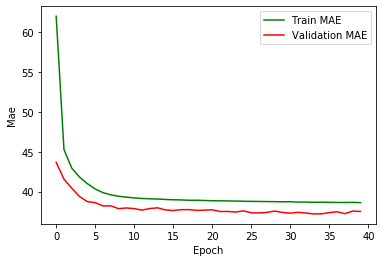

In [14]:
plot_history(CNN_history)

"Current pollution" baseline:
 train mae =  38.616085 
 validation mae =  37.520535
(30011, 1)
(4971, 1)


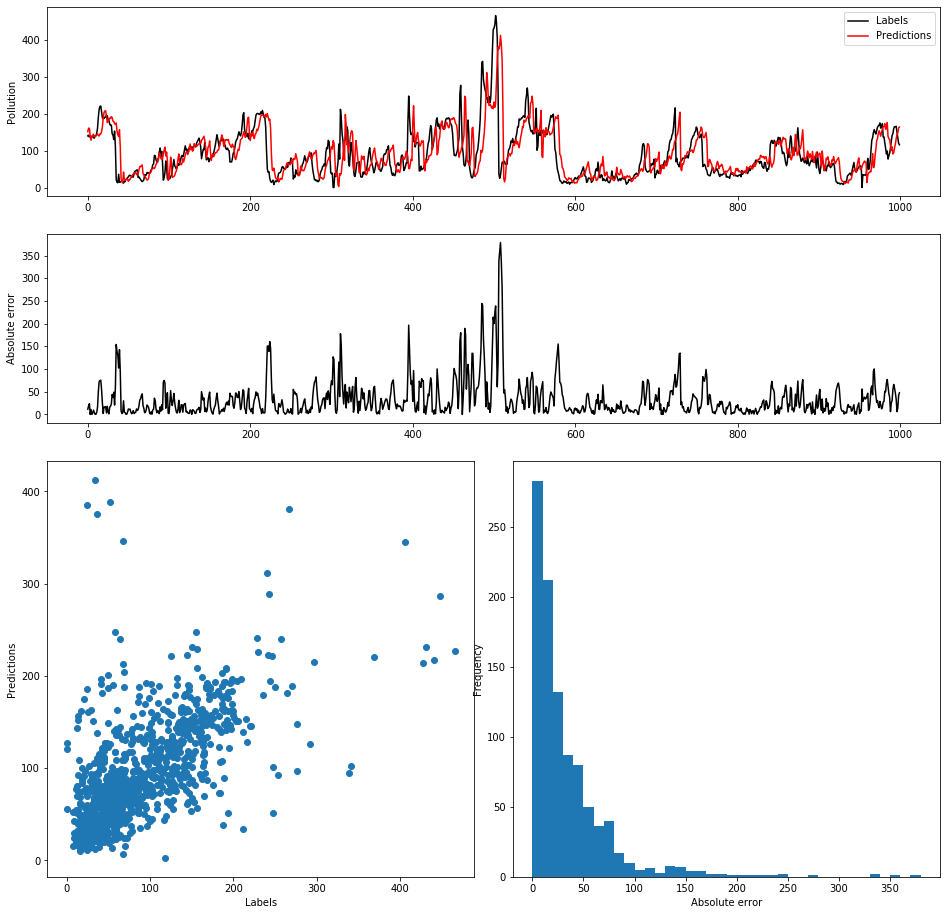

In [15]:
y_train_CNNmodel = CNNmodel.predict(X_train_w)
y_val_CNNmodel = CNNmodel.predict(X_val_w)

mae_train_CNNmodel = mean_absolute_error(r_train_w,y_train_CNNmodel)
mae_val_CNNmodel = mean_absolute_error(r_val_w,y_val_CNNmodel)

print("\"Current pollution\" baseline:\n train mae = ",mae_train_CNNmodel,
      "\n validation mae = ",mae_val_CNNmodel)

print(y_train_CNNmodel.shape)
print(y_val_CNNmodel.shape)

# Visualise first 1000 predictions for validation
PlotResults(r_val_w[:1000],y_val_CNNmodel[:1000,0])

When tuning your convolutional model, try to think about the receptive fields of the features you extract (cf. lecture). The current network only has two layers of 2x2 filters, so the receptive fields are very small!!

The final model type is a recurrent model, which is demonstrated in the code below. Remember that LSTMs require the input data to be scaled between 0 and 1!! Since currently, a standardscaler was used, the code below does not give useful results.

In [19]:
HIDDEN_RNN = 4
LSTM_WINDOW_SIZE = 8

# current code for pollution-only, add other features for multi-feature model, 
# remove indices as in commented code if you want to use all features
train_features = [0,] 

X_train_w,r_train_w = create_dataset_windowed(train_scaled[:,train_features],train_labels, window_size=LSTM_WINDOW_SIZE)
X_val_w,r_val_w = create_dataset_windowed(val_scaled[:,train_features],val_labels, window_size=LSTM_WINDOW_SIZE)

X_train_all_w,r_train_all_w = create_dataset_windowed(train_all_scaled[:,train_features],train_all_labels, window_size=LSTM_WINDOW_SIZE)
X_test_w,r_test_w = create_dataset_windowed(test_scaled[:,train_features],test_labels, window_size=LSTM_WINDOW_SIZE)

#X_train_w,r_train_w = create_dataset_windowed(train_scaled,train_labels, window_size=LSTM_WINDOW_SIZE)
#X_val_w,r_val_w = create_dataset_windowed(val_scaled,val_labels, window_size=LSTM_WINDOW_SIZE)

#X_train_all_w,r_train_all_w = create_dataset_windowed(train_all_scaled,train_all_labels, window_size=LSTM_WINDOW_SIZE)
#X_test_w,r_test_w = create_dataset_windowed(test_scaled,test_labels, window_size=LSTM_WINDOW_SIZE)

# regularisers for LSTM - all set to zero for now
wreg = L1L2(l1=0.0, l2=0.0)


LSTMmodel = Sequential()

# Note that you can also make multi-layer LSTMs 
# Since these send their output to another LSTM, they should output whole sequences 
# instead of predictions
# For this reason, all but the last LSTM layer should have return_sequences=True

LSTMmodel.add(LSTM(input_shape = (LSTM_WINDOW_SIZE,1), 
                   units=HIDDEN_RNN,
                   return_sequences=False, 
                   kernel_regularizer=wreg))
LSTMmodel.add(Dense(1))
LSTMmodel.add(Activation('linear'))
LSTMmodel.summary()

LSTMmodel.compile(optimizer=tf.keras.optimizers.Adam(),loss='mae', metrics=['mae'])


batch_size=64
epochs=100
LSTM_history = LSTMmodel.fit(X_train_w, r_train_w, 
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val_w, r_val_w),
          shuffle=True)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 4)                 96        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 5         
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
Train on 30027 samples, validate on 4987 samples
Epoch 1/100
30027/30027 [==============================] - 4s 136us/sample - loss: 91.9305 - mae: 91.9305 - val_loss: 82.4817 - val_mae: 82.4817
Epoch 2/100
30027/30027 [==============================] - 2s 73us/sample - loss: 88.4199 - mae: 88.4199 - val_loss: 79.7346 - val_mae: 79.7346
Epoch 3/100
30027/30027 [=======================

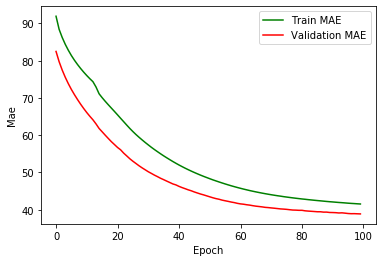

In [20]:
plot_history(LSTM_history)

"Current pollution" baseline:
 train mae =  41.50288 
 validation mae =  38.874622


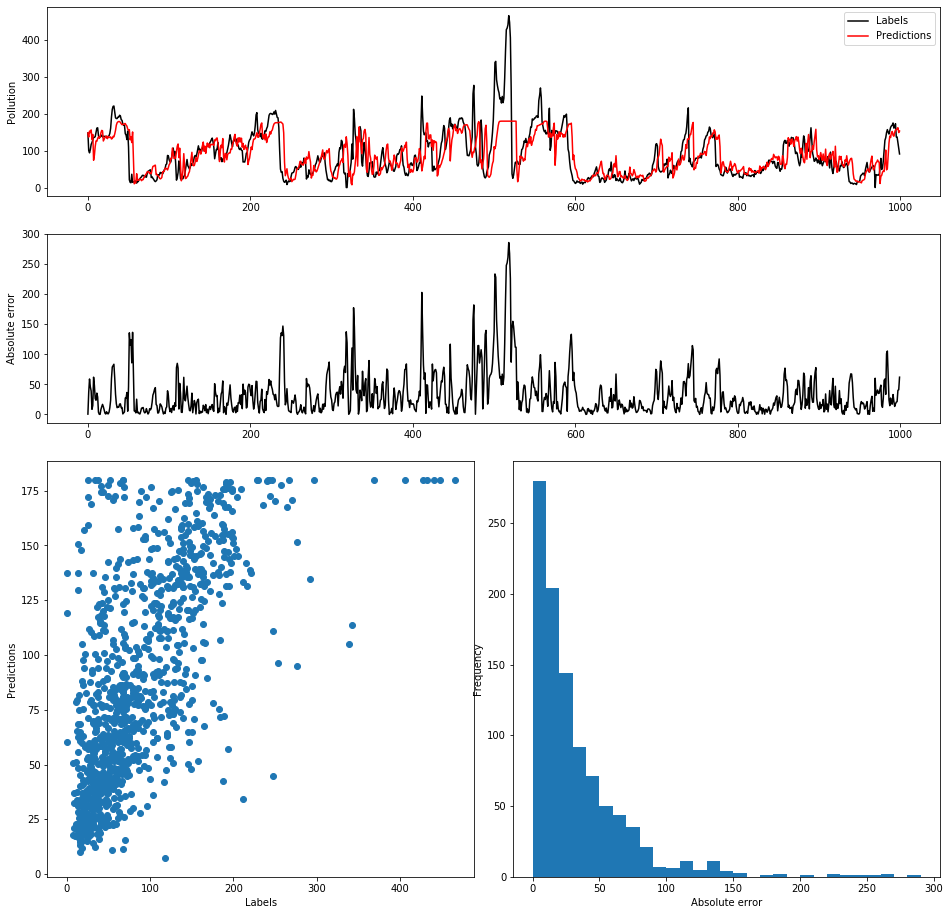

In [22]:
y_train_LSTMmodel = LSTMmodel.predict(X_train_w)
y_val_LSTMmodel = LSTMmodel.predict(X_val_w)

mae_train_LSTMmodel = mean_absolute_error(r_train_w,y_train_LSTMmodel)
mae_val_LSTMmodel = mean_absolute_error(r_val_w,y_val_LSTMmodel)

print("\"Current pollution\" baseline:\n train mae = ",mae_train_LSTMmodel,
      "\n validation mae = ",mae_val_LSTMmodel)

# Visualise first 1000 predictions for validation
PlotResults(r_val_w[:1000],y_val_LSTMmodel[:1000,0])

Now it's up to you to try and improve these models and understand, for this particular problem, what would work and what wouldn't!